In [3]:
from Bio.PDB import *
from Bio import BiopythonWarning
import warnings
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import time
import os
import matplotlib.pyplot as plt
from collections import defaultdict

%matplotlib inline

warnings.simplefilter('ignore', BiopythonWarning)

In [4]:

def read_protein_list(identification, method, header = "ALL"):
    '''
        Read a full protein list from "pdb_entry_type.txt" and return a np.array with
        1 colomn : PDB entry, eg "2oar" without ".pdb"
        2 colomn : protein (prot), nucleie acid (nuc), or protein-nucleic acid complex (prot-nuc)
        3 colomn : determined by diffraction or NMR 
        4 colomn : the protein type, eq, membrane protein.
    '''
    residue_list = []
    PDB_entry = []
    with open("pdb_entry_type.txt", "r") as f :
        residue_list = f.readlines()
        for i in range(len(residue_list)):
            count_star = 0; count_end = 0
            tmp_string = []
            for string in residue_list[i]:
                if string not in ["\t","\n"]:
                    count_end += 1
                else :
                    tmp_string.append(residue_list[i][count_star:count_end])
                    count_end += 1
                    count_star = count_end
            PDB_entry.append(tmp_string)

    with open("entries.idx", "r") as f:
        data = f.readlines()
        del data[0:2] # delete first two rows 
        for i in range(len(data)):
            count_star = 0; count_end = 0
            tmp_string = []
            for string in data[i]:
                if string not in ["\t","\n"]:
                    count_end += 1
                else :
                    tmp_string.append(data[i][count_star:count_end])
                    count_end += 1
                    count_star = count_end
            PDB_entry[i].append(tmp_string[1]) # append the second element (the header) to the PDB list
    PDB_entry = np.array(PDB_entry)
    
    #print(PDB_entry[:,2] == method)
    
    PDB_entry = PDB_entry[(PDB_entry[:,1] == identification) & (PDB_entry[:,2] == method)]
    if header == "ALL":
        return PDB_entry
    else :
        return np.array([entry for entry in PDB_entry if header in entry[3]])

    
    #print(PDB_entry)

In [5]:
# The table of amino acid residues and their label
table = {'GLY': 0, 'ALA': 1, 'VAL': 2, 'LEU': 3,
         'ILE': 4, 'MET': 5, 'CYS': 6, 'SER': 7, 
         'THR': 8, 'ASN': 9, 'GLN':10, 'ASP':11, 
         'GLU':12, 'LYS':13, 'ARG':14, 'HIS':15, 
         'PHE':16, 'TYR':17, 'TRP':18, 'PRO':19,
}

def load_residue_CIF(CIF_entry):
    """
        Load protein residue seqence from a PDB file with entry PDB_entry
        Ref: http://biopython.org/DIST/docs/api/Bio.PDB.MMCIFParser%27-pysrc.html
    """
    
    #download protein structure from PDB
    WORKDIR = os.getcwd()+"/PDB_entries/"
    
    pdbl = PDBList()
    pdbl.retrieve_pdb_file(CIF_entry, file_format="mmCif", pdir=WORKDIR, overwrite=False)
    entry_name = WORKDIR+CIF_entry+".cif"
    
    # Read protein structure from the directory PDB_entries
    mmcif_dict = MMCIF2Dict.MMCIF2Dict(entry_name)
    
    atom_id_list = mmcif_dict["_atom_site.label_atom_id"] 
    residue_id_list = mmcif_dict["_atom_site.label_comp_id"] 
    label_asym_id = mmcif_dict["_atom_site.label_asym_id"]
    label_seq_id = mmcif_dict["_atom_site.label_seq_id"]
    label_alt_id = mmcif_dict["_atom_site.label_alt_id"]
    x_list = mmcif_dict["_atom_site.Cartn_x"]
    y_list = mmcif_dict["_atom_site.Cartn_y"]
    z_list = mmcif_dict["_atom_site.Cartn_z"]
    
    sec_struc = ["other" for _ in range(len(label_asym_id))] # The label of secondary structure of each residue
    
    ##### Label residues that form alpha helix #####
    try:
        alpha_hel_label_asym_id = mmcif_dict["_struct_conf.beg_label_asym_id"]
        alpha_hel_beg_label_seq_id = mmcif_dict["_struct_conf.beg_label_seq_id"]
        alpha_hel_end_label_seq_id = mmcif_dict["_struct_conf.end_label_seq_id"]
    except:
        alpha_hel_label_asym_id = []
        alpha_hel_beg_label_seq_id = []
        alpha_hel_end_label_seq_id = []
        print("The protein ("+CIF_entry+") has no alpha helix")

    alpha_hel_dict = defaultdict(list)
    for asym_id, beg, end in zip(alpha_hel_label_asym_id, alpha_hel_beg_label_seq_id, alpha_hel_end_label_seq_id):
        alpha_hel_dict[asym_id].append(((int(beg)), int(end)))
    
    for i, (asym_id, seq_id) in enumerate(zip(label_asym_id,label_seq_id)):
        for range_id in alpha_hel_dict[asym_id]:
            if int(seq_id) in range(range_id[0], range_id[1]+1):
                sec_struc[i] = "alpha" 
    ################################################

    ##### Label residues that form beta sheet #####
    try:
        beta_sheet_label_asym_id = mmcif_dict["_struct_sheet_range.beg_label_asym_id"]
        beta_sheet_beg_label_seq_id = mmcif_dict["_struct_sheet_range.beg_label_seq_id"]
        beta_sheet_end_label_seq_id = mmcif_dict["_struct_sheet_range.end_label_seq_id"]    
    except:
        beta_sheet_label_asym_id = []
        beta_sheet_beg_label_seq_id = []
        beta_sheet_end_label_seq_id = []
        print("The protein ("+CIF_entry+") has no beta sheet")

    beta_sheet_dict = defaultdict(list)
    for asym_id, beg, end in zip(beta_sheet_label_asym_id, beta_sheet_beg_label_seq_id, beta_sheet_end_label_seq_id):
        beta_sheet_dict[asym_id].append(((int(beg)), int(end)))
    
    for i, (asym_id, seq_id) in enumerate(zip(label_asym_id,label_seq_id)):
        for range_id in beta_sheet_dict[asym_id]:
            if int(seq_id) in range(range_id[0], range_id[1]+1):
                sec_struc[i] = "beta" 
    ###############################################

    structure = [(residue_id, sec_str, np.array([float(x), float(y), float(z)])) \
                 for atom_id, sec_str, residue_id, alt_id, x, y, z in zip(atom_id_list,sec_struc,residue_id_list,label_alt_id, x_list,y_list,z_list) \
                 if atom_id == "CA" and residue_id in table.keys() and (alt_id == "." or alt_id == "A")
                ]
    return structure


def protein_lists(protein_list):
    '''
        This function takes a list of proteins 
        and returns 
        residue_id:    a list of residue id
        residue_coord: a list of residue coordinate
    '''
    proteins = [ load_residue_CIF(protein) for protein in protein_list ]
    residue_id = []
    residue_str = []
    residue_coord = []
    for protein in proteins :
        res_id, res_str, res_coord = zip(*protein)
        residue_id.append(np.array(res_id))
        residue_str.append(np.array(res_str))
        residue_coord.append(np.array(res_coord))
    return residue_id, residue_str, residue_coord


In [6]:
# Read a list of all obsolete entries ever in the PDB.
obsolete_list = PDBList().get_all_obsolete()

# A list of molecules that are not proteins but contain "prot" in their description
# which can be identified by the fact that they have no alpha helix and beta sheet
not_a_protein = ["4r0p","3NVH","5WHN","5WIA","5WKD","5ZCK","6C3F","6C3G","6C3T","6C4O","6C88","6CB9","6CEW","6BWZ","6BXV","6BXX","6BZM","6BZP"]

# Read the full protein list
protein_list = read_protein_list("prot","diffraction","ALL") 
#protein_list = read_protein_list("prot","diffraction","MEMBRANE") 
protein_list = protein_list[:,0] # keep the PDB entry (first column) in the list

# Remove obsoleted proteins from the list
protein_list = np.array([entry for entry in protein_list if entry not in obsolete_list and entry not in not_a_protein] )

# Rrandomly chose N_Ligase proteins from protein_list
N_Ligase = 50
protein_list = protein_list[np.random.choice(len(protein_list), N_Ligase, replace=False)]
print(protein_list)

resid_in_prots, resstruc_in_prots, rescoor_in_prots = protein_lists(protein_list)



['5pzl' '1bay' '1ifa' '2r8o' '2phw' '5pqu' '5k3h' '1maz' '1qr2' '4xnw'
 '1iy8' '1irx' '2min' '4fxe' '1jb4' '4q0c' '2hih' '3t2o' '5kix' '2h0m'
 '5sw8' '4y6c' '5b3j' '3wzt' '2pzg' '5dmg' '2j50' '4dt9' '4mq9' '4cf8'
 '5b70' '2oic' '1h7z' '4l3l' '2jik' '2ii6' '4kwl' '1b02' '3bet' '5b86'
 '4cd7' '5jh5' '2ql6' '3mhb' '1rw0' '4njs' '1dmm' '3mhi' '2erk' '2eus']
The protein (1ifa) has no beta sheet
The protein (5pqu) has no beta sheet
The protein (1maz) has no beta sheet
The protein (2h0m) has no beta sheet
The protein (4y6c) has no beta sheet


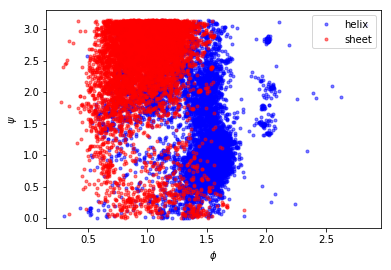

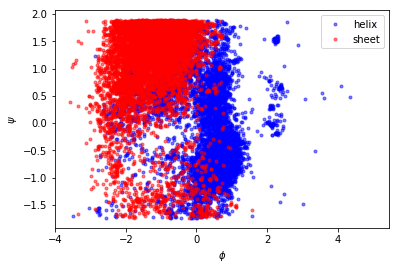

In [16]:
def distance(v1,v2):
    return np.sqrt(np.sum(np.power(v1-v2,2)))

def angle(i_protein,a,b,c,v1,v2,v3=[0,0,0]):
    v12 = (v1-v2)/distance(v1,v2)
    v23 = (v2-v3)/distance(v2,v3)
    
    if( distance(v1,v2) < 0.000001):
        print(i_protein,a,b,c,np.dot(v12,v23),np.cross(v12,v23),v1,v2,v3,distance(v1,v2))
    if( distance(v2,v3) < 0.000001):
        print(i_protein,a,b,c,np.dot(v12,v23),np.cross(v12,v23),v1,v2,v3,distance(v2,v3))
        
    return np.arccos(np.dot(v12,v23))

def normal_vector(v1,v2,v3):
    v12 = (v1-v2)/distance(v1,v2)
    v23 = (v2-v3)/distance(v2,v3)

    v = np.cross(v12,v23)
    
    if( np.fabs(np.dot(v12,v23)) < 0.000001):
        print(np.dot(v12,v23),np.cross(v12,v23),v1,v2,v3)
        
    return v / np.sqrt(np.sum(np.power(v,2)))

# the fourth protein has a lot of beta sheets
# the fifth protein has a lot of alpha helix

phi = []
psi = []
struc = []
for i_protein in range(len(rescoor_in_prots)):
    coord = rescoor_in_prots[i_protein]
    struc = np.append(struc, resstruc_in_prots[i_protein][1:-2])

    phi = np.append(phi, [angle(i_protein,i-1,i,i+1,coord[i-1],coord[i],coord[i+1]) for i in range(1,len(coord)-1)][:-1] )
    nor_vec = [normal_vector(coord[i-1],coord[i],coord[i+1]) for i in range(1,len(coord)-1)]
    psi = np.append(psi, [np.arccos(np.dot(nor_vec[i],nor_vec[i+1])) for i in range(0,len(nor_vec)-1 )])

plt.plot(phi[struc=="alpha"],psi[struc=="alpha"],"b.",alpha=0.5, label="helix")
plt.plot(phi[struc=="beta"],psi[struc=="beta"],"r.",alpha=0.5, label="sheet")
plt.legend(loc=1)
#plt.plot(phi[struc=="other"],psi[struc=="other"],"g.",alpha=0.5)

plt.xlabel("$\phi$")
plt.ylabel("$\psi$")
plt.show()

phi_alpha_beta = np.array([phii for phii, strucc in zip(phi, struc) if strucc != 'other'])
phi_alpha_beta = (phi_alpha_beta - np.mean(phi_alpha_beta))/np.std(phi_alpha_beta) #normalization
psi_alpha_beta = np.array([psii for psii, strucc in zip(psi, struc) if strucc != 'other'])
psi_alpha_beta = (psi_alpha_beta - np.mean(psi_alpha_beta))/np.std(psi_alpha_beta) #normalization
struc_alpha_beta = np.array([strucc for strucc in struc if strucc != 'other'])

plt.plot(phi_alpha_beta[struc_alpha_beta=="alpha"],psi_alpha_beta[struc_alpha_beta=="alpha"],"b.",alpha=0.5, label="helix")
plt.plot(phi_alpha_beta[struc_alpha_beta=="beta"],psi_alpha_beta[struc_alpha_beta=="beta"],"r.",alpha=0.5, label="sheet")
plt.xlabel("$\phi$")
plt.ylabel("$\psi$")
plt.legend(loc=1)
plt.show()

In [8]:
import sklearn.model_selection as skms
#prepare data format for training
X_all = np.array([[phii, psii] for phii,psii in zip(phi_alpha_beta,psi_alpha_beta)])
y_all = np.array([0 if structure == "alpha" else 1 if structure == "beta" else 2 for structure in struc_alpha_beta])

from collections import Counter

count_strucutre = Counter(y_all)
print(count_strucutre, count_strucutre[1])

p_alpha = count_strucutre[0] / ( count_strucutre[0]+ count_strucutre[1])
p_beta = count_strucutre[1] / ( count_strucutre[0]+ count_strucutre[1])

X = []
y = []
for xi, yi in zip(X_all, y_all) :
    if yi == 0 and np.random.rand() < p_beta :
        X.append(xi)
        y.append(yi)
    elif yi == 1 and np.random.rand() < p_alpha :
        X.append(xi)
        y.append(yi)

X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = skms.train_test_split(X,y, test_size=0.2)

print(Counter(y))

Counter({0: 20762, 1: 8937}) 8937
Counter({0: 6238, 1: 6220})


In [9]:
import keras.models as km
import keras.layers as kl
import keras.utils as ku

def get_model(numnodes, input_size = 2, output_size = 2, d_rate = 0.4):

    """
    This function returns a simple Keras model, consisting of a
    re-implementation of the second_network.py neural network, with
    numnodes in the hidden layer.

    Inputs:
    - numnodes: int, the number of nodes in the hidden layer.

    - intput_size: int, the size of the input data, default = 784.

    - output_size: int, the number of nodes in the output layer,
      default = 10.

    Output: the constructed Keras model.

    """

    # Initialize the model.
    model = km.Sequential()

    # Add a hidden fully-connected layer.
    model.add(kl.Dense(numnodes, input_dim = input_size, activation = 'tanh'))

    #model.add(kl.BatchNormalization())
    #model.add(kl.Dropout(d_rate))
    
    # Add the output layer.
    model.add(kl.Dense(output_size, activation = 'softmax'))

    # Return the model.
    return model

Using TensorFlow backend.


In [10]:
#prepare data format for training using neutron network 
X_train, X_test, y_train, y_test = skms.train_test_split(X,y, test_size=0.2)

# secondary structure labels must be changed to a catagorical formant (one-hot encoding)
y_train = ku.to_categorical(y_train, 2)
y_test = ku.to_categorical(y_test, 2)

In [11]:
model = get_model(20)
model.summary()

#model.compile(optimizer='sgd',metrics=['accuracy'], loss="mean_squared_error")
model.compile(optimizer='adam',metrics=['categorical_accuracy'], loss="categorical_crossentropy")
fit = model.fit(X_train, y_train, epochs=100, batch_size=20, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                60        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 42        
Total params: 102
Trainable params: 102
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.evaluate(X_test,y_test)

2492/2492 [==============================] - 0s 31us/step


[0.16111613697645943, 0.9345906904000149]

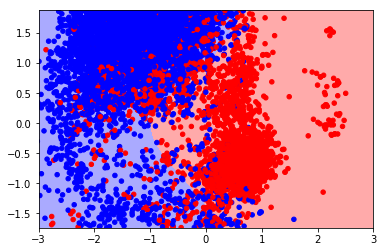

In [29]:
from sklearn import neighbors
from matplotlib.colors import ListedColormap

#n_neighbors = 30
h = 0.01
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
   
x_min, x_max = X[:, 0].min() , X[:, 0].max() 
y_min, y_max = X[:, 1].min() , X[:, 1].max() 

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=20)
plt.xlim(-3.0, 3.0)
plt.ylim(yy.min(), yy.max())
plt.show()